In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib

clear_output()

In [2]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) / 2
    return cost

def compute_terminal_cost(x):
    cost = casadi.dot(Q_f@x,x) / 2
    return cost

In [4]:
def make_nlp():
    F_RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0
    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - F_RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [6]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

solution_time_result_list = []
U_result_list = []

for initialize_flag in [0,1,2]:

    sol_time_list = []
    for _ in range(10):
        x_init = casadi.DM([0,np.pi,0,0]) # 初期値
        x0 = casadi.DM.zeros(total)
        
        I = make_integrator()
        
        X = [x_init]
        U = []
        x_current = x_init
            
        tmp_sol_time = []
        S = make_nlp()
        F_RK4 = make_RK4()
        
        for t in t_eval:
            start_time = time.time()
            if initialize_flag == 0:
                # cold start (zero initialization)
                x0 = casadi.DM.zeros(total)
            elif initialize_flag == 1:
                # warm start (simple initialization)
                pass
            elif initialize_flag == 2:
                # warm start (shift initialization) 
                offset = nx*(K+1)
                xN_previous = x0[nx*K:offset]
                uNm1_previous = x0[-nu:]
                xN = F_RK4(x=xN_previous,u=uNm1_previous)["x_next"]
                x0 = casadi.DM(
                       casadi.vertcat(
                        x0[nx:offset], uNm1_previous, x0[offset+nu:], xN
                       )
                     )
            u_opt,x0 = compute_optimal_control(S,x_current,x0)
            tmp_sol_time.append(time.time()-start_time)
            x_current = I(x0=x_current,p=u_opt)["xf"]
            X.append(x_current)
            U.append(u_opt)
        X.pop()
        X = np.array(X).reshape(t_eval.size,nx)
        U = np.array(U).reshape(t_eval.size,nu)
        tmp_sol_time = np.array(tmp_sol_time)
        sol_time_list.append(tmp_sol_time)
    U_result_list.append(1*U)
    solution_time_result_list.append(np.array(sol_time_list).mean(0))



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



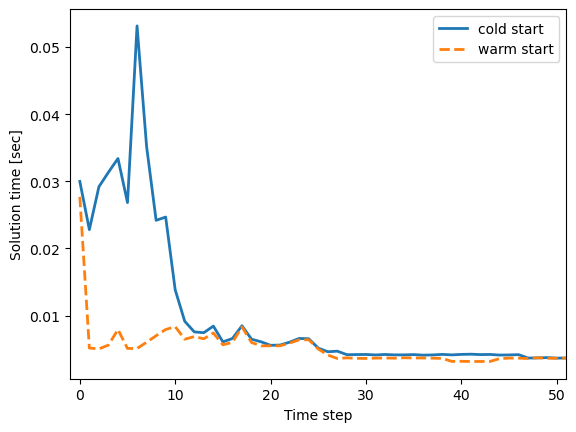

In [7]:
plt.plot(solution_time_result_list[0],linewidth=2,label="cold start")
plt.plot(solution_time_result_list[1],"--",linewidth=2,label="warm start")
# plt.plot(solution_time_result_list[2],":",linewidth=2,label="warm start (shift initialize)")
plt.xlabel("Time step")
plt.ylabel("Solution time [sec]")
plt.xlim([-1,51])
plt.legend()
plt.savefig("images/chap6_warm_start_experiment_solution_time.png")

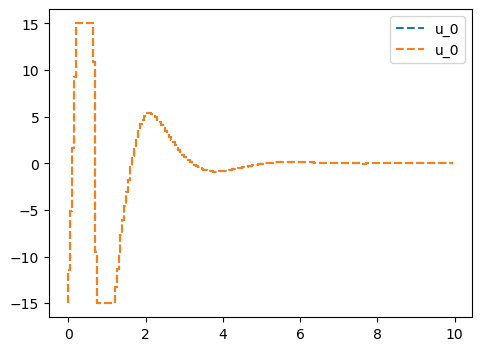

In [8]:

plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
# for k in range(nx):
#     plt.plot(t_eval,X[:,k],label=f"x_{k}")
# plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U_result_list[0][:,k],linestyle="--",label=f"u_{k}")
    plt.step(t_eval,U_result_list[1][:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()